#BigData Final Proyect by Juan Murillo Murillo 2024/25

Soy Juan Murillo Murillo, alumno del Máster de Biología Computacional.

A continuación presento mi ejercicio final de la asignatura Big Data.

El trabajo consiste en, utlizando un modelo de entrenamiento supervisado, clasificar imágenes de pacientes de rayos X con neuomonía o sin ella.

Concretamente, me centraré en el diseño de una red neuornal convolucional utilizando la API de BigDL.

El código a continuación esta diseñado específicamente para ser utilizado en Colab.

#Descarga de BigDL & Java

Primero que nada, comenzamos preparando las librerias que son necesarias para ejecutar el codigo.

Los datos pueden tanto descargarse desde Kaggle como importarlos desde Drive.

LINK Kaggle: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

En mi caso, lo hago desde Drive.



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/bigdl_dllib_spark3-0.14.0b20211107-py3-none-manylinux1_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 8.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880746 sha256=95bb8be17203a98c028ea31bd56d69ed048446f451d3c6d067fc3b56b9b3baa6
  Stored in directory: /root/.cache/pip/wheels/ef/70/50/7882e1bcb5693225f7cc86698f10953201b48b3f36317c2d18
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.3
    Uninstalling pyspark-3.5.3:
      Successfully uninstalled pyspark-3.5.3


Con el codigo que se muestra a continuacion, nos aseguramos solo tener la version de bigdl como de spark necesarias siendo estas:

--bigdl-dllib-spark3                 0.14.0b20211107

--pyspark                            3.1.2

Esto es sumamente importante, puesto que la documentacion que habra de ser revisada tiene que ser de estas versiones o compatible con las mismas para evitar conflictos.

La documentación fue obtenida principalmente de la pagina oficial: https://bigdl.readthedocs.io/en/latest/doc/DLlib/index.html

Para las funciones, utilize la funcion help() para obtener los parámetros que pueden incluirse en las mismas.

In [ ]:
!pip list | grep spark

bigdl-dllib-spark3                 0.14.0b20211107
pyspark                            3.1.2


Además, se requiere Java, por lo que lo instalo en la sesion de Colab.

In [ ]:
#Instalacion de jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import zipfile
import os

#Establecer la variable de entorno JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version


update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_432"
OpenJDK Runtime Environment (build 1.8.0_432-8u432-ga~us1-0ubuntu2~22.04-ga)
OpenJDK 64-Bit Server VM (build 25.432-bga, mixed mode)


Proseguimos con la importacion de los datos.

Obtenemos las imagenes de las clases del dataset (Normal y Pneumonia).

Construimos los dataframes de entrenamiento, validacion y test.



In [ ]:
import glob
import numpy as np
import pandas as pd

# Definición de rutas
train_path = "/content/drive/MyDrive/MasterDrive/chest_xray/train"
test_path = "/content/drive/MyDrive/MasterDrive/chest_xray/test"
val_path = "/content/drive/MyDrive/MasterDrive/chest_xray/val"

# Obtener listas de imágenes
train_normal = glob.glob(train_path + "/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path + "/PNEUMONIA/*.jpeg")
test_normal = glob.glob(test_path + "/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path + "/PNEUMONIA/*.jpeg")
val_normal = glob.glob(val_path + "/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path + "/PNEUMONIA/*.jpeg")

# Listas completas
train_list = train_normal + train_pneumonia
test_list = test_normal + test_pneumonia
val_list = val_normal + val_pneumonia

# Crear DataFrames
df_train = pd.DataFrame({'label': ['Normal'] * len(train_normal) + ['Pneumonia'] * len(train_pneumonia),
                         'image_path': train_list})
df_test = pd.DataFrame({'label': ['Normal'] * len(test_normal) + ['Pneumonia'] * len(test_pneumonia),
                        'image_path': test_list})
df_val = pd.DataFrame({'label': ['Normal'] * len(val_normal) + ['Pneumonia'] * len(val_pneumonia),
                       'image_path': val_list})


# Preprocesamiento de las imagenes

Lo primero que debemos hacer es analizar las dimensiones y las características de las imágenes disponibles.

Se trata de imágenes en formato .JPEG con dimensiones variables en torno a los 1000x1000 píxeles y una profundidad de 8 bits, lo que indica que están en escala de grises.

Sin embargo, al inspeccionar las dimensiones de las imágenes, observamos la presencia de 3 canales de color en su estructura. Por ejemplo: (1128, 1422, 3).

Al analizar en detalle la contribución de cada canal de color, notamos que los valores de los tres canales son idénticos. Esto sugiere que las imágenes originalmente estaban en blanco y negro, pero, posiblemente durante la creación del dataframe, fueron convertidas a un formato RGB donde cada canal contiene los mismos valores de píxeles.

Image Dimensions (H x W x C): (1368, 1546, 3)
The image at /content/drive/MyDrive/MasterDrive/chest_xray/train/NORMAL/NORMAL2-IM-0642-0001.jpeg is grayscale.
Image Dimensions (H x W x C): (632, 1104, 3)
The image at /content/drive/MyDrive/MasterDrive/chest_xray/train/PNEUMONIA/person1062_virus_1762.jpeg is grayscale.
Displaying image from: /content/drive/MyDrive/MasterDrive/chest_xray/train/NORMAL/NORMAL2-IM-0642-0001.jpeg


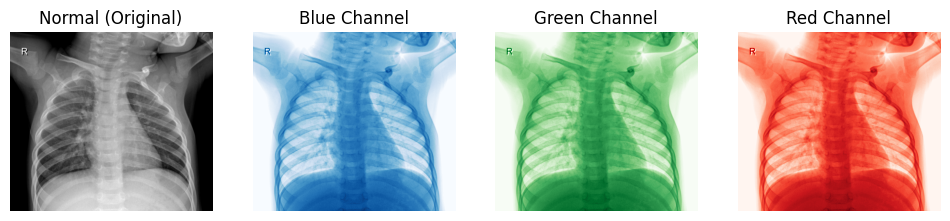

Displaying image from: /content/drive/MyDrive/MasterDrive/chest_xray/train/PNEUMONIA/person1062_virus_1762.jpeg


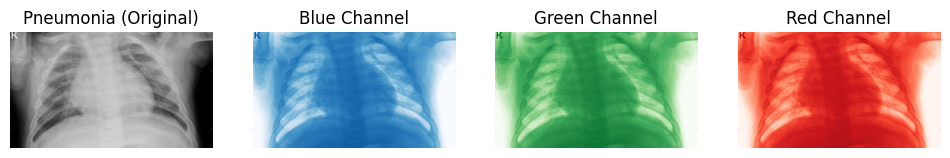

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def show_color_channels(image, title="Image"):
    # Separar canales
    blue_channel, green_channel, red_channel = cv2.split(image)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"{title} (Original)")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(blue_channel, cmap='Blues')
    plt.title("Blue Channel")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(green_channel, cmap='Greens')
    plt.title("Green Channel")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(red_channel, cmap='Reds')
    plt.title("Red Channel")
    plt.axis('off')

    plt.show()

# Función para verificar si las imagenes originales son en blanco y negro
def check_grayscale(image):

    blue_channel, green_channel, red_channel = cv2.split(image)
    is_grayscale = np.allclose(blue_channel, green_channel) and np.allclose(green_channel, red_channel)

    return is_grayscale

# Seleccionar aleatoriamente una imagen de cada clase
def get_random_image(df, label, image_column='image_path'):

    subset = df[df['label'] == label]

    random_image_path = random.choice(subset[image_column].tolist())
    image = cv2.imread(random_image_path, cv2.IMREAD_COLOR)

    print(f"Image Dimensions (H x W x C): {image.shape}")

    # Verificar si la imagen es en escala de grises
    if check_grayscale(image):
        print(f"The image at {random_image_path} is grayscale.")
    else:
        print(f"The image at {random_image_path} is in color.")

    return image, random_image_path

# Extraer imágenes de las dos clases
random_normal_image, normal_path = get_random_image(df_train, label='Normal')
random_pneumonia_image, pneumonia_path = get_random_image(df_train, label='Pneumonia')

if random_normal_image is not None:
    print(f"Displaying image from: {normal_path}")
    show_color_channels(random_normal_image, title="Normal")

if random_pneumonia_image is not None:
    print(f"Displaying image from: {pneumonia_path}")
    show_color_channels(random_pneumonia_image, title="Pneumonia")


El preprocesamiento de las imágenes se ha llevado a cabo siguiendo cuatro pasos principales:

-Transformación a escala de grises: Las imágenes se convierten de RGB a escala de grises para recuperar la version original.

-Compresión de la imagen: Las imágenes se redimensionan a un tamaño más manejable para adaptarse a la capa de entrada de la red neuronal.

-Normalización de valores: Los valores de los píxeles se escalan entre 0 y 1 para estandarizar los datos y facilitar el entrenamiento del modelo.

-Ajuste de la dimensión: Se añade una dimensión extra para conformar el formato de entrada requerido por el modelo, obteniendo un shape final de (1, 64, 64).

**Consideraciones adicionales**

Ponderaciones de los canales de color:
Según la documentación de OpenCV, muchas funciones predefinidas que transforman imágenes aplican ponderaciones específicas a los canales de color, lo que puede alterar significativamente su contribución. En este caso, dado que los canales son idénticos, no hay impacto en la conversión a escala de grises. Sin embargo, se recomienda definir manualmente la ponderación de los canales para garantizar una mayor trazabilidad y control sobre los valores de los píxeles.

Compresión de las imágenes:
Dado que las redes neuronales tienen limitaciones en el tamaño de entrada (generalmente hasta 224x224), es necesario comprimir las imágenes a un tamaño más reducido. En este caso, se seleccionaron dimensiones de 64x64 para adaptarse a las restricciones computacionales de Google Colab en su versión gratuita, maximizando el rendimiento mientras se intenta capturar la mayor cantidad de información posible.

Interpolación en cv2.resize:
OpenCV utiliza interpolación para calcular los valores de los píxeles en las imágenes redimensionadas. Por defecto, emplea el método cv2.INTER_LINEAR, que utiliza una ponderación lineal de los 2x2 píxeles adyacentes para determinar el valor del nuevo píxel.

Orden de los canales de color:
Es fundamental verificar si el modelo utilizado requiere que el canal de color esté en la primera o en la última posición de las dimensiones de la imagen. Este detalle debe ajustarse al preprocesar las imágenes para garantizar la compatibilidad con el modelo.

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm

# Barra de progreso
tqdm.pandas()

# Función para convertir a escala de grises
def custom_grayscale(image, weights=(0.333, 0.333, 0.334)):

    b, g, r = cv2.split(image)
    gray_image = weights[0] * b + weights[1] * g + weights[2] * r
    return gray_image

# Función de preprocesamiento
def preprocess_image(image_path, target_size=(64, 64), weights=(0.333, 0.333, 0.334)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convertir a escala de grises
    image_gray = custom_grayscale(image, weights=weights)

    # Normalizar valores entre 0 y 1
    image_normalized = image_gray / 255.0

    # Cambiar tamaño
    image_resized = cv2.resize(image_normalized, target_size)

    # Expande las dimensiones para tensor (H, W, 1)
    return np.expand_dims(image_resized, axis=0)   # Axis 0 = (1, 64, 64)

# Aplicar para cada DataFrame y verificación
df_train['processed_image'] = df_train['image_path'].progress_apply(lambda x: preprocess_image(x, weights=(0.3, 0.4, 0.3)))
df_test['processed_image'] = df_test['image_path'].progress_apply(lambda x: preprocess_image(x, weights=(0.3, 0.4, 0.3)))
df_val['processed_image'] = df_val['image_path'].progress_apply(lambda x: preprocess_image(x, weights=(0.3, 0.4, 0.3)))

print(df_train.head())

100%|██████████| 16/16 [00:04<00:00,  3.99it/s]

    label                                         image_path  \
0  Normal  /content/drive/MyDrive/MasterDrive/chest_xray/...   
1  Normal  /content/drive/MyDrive/MasterDrive/chest_xray/...   
2  Normal  /content/drive/MyDrive/MasterDrive/chest_xray/...   
3  Normal  /content/drive/MyDrive/MasterDrive/chest_xray/...   
4  Normal  /content/drive/MyDrive/MasterDrive/chest_xray/...   

                                     processed_image  
0  [[[0.20401252297794117, 0.32193053002450983, 0...  
1  [[[0.0, 0.0550848268995098, 0.0849044500612745...  
2  [[[0.861703431372549, 0.8717524509803921, 0.88...  
3  [[[0.22290469898897058, 0.26610035615808825, 0...  
4  [[[0.1941162109375, 0.1962024165134804, 0.1897...  


Comenzamos creando tanto la sesion de spark como el contexto de BigDL.



In [ ]:
# Inicializar Spark y BigDL
from pyspark.sql import SparkSession
from bigdl.dllib.nncontext import *
sc = init_nncontext(cluster_mode="local", seed=42)
spark = SparkSession(sc)

Prepending /usr/local/lib/python3.10/dist-packages/bigdl/share/dllib/conf/spark-bigdl.conf to sys.path
Current pyspark location is : /usr/local/lib/python3.10/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.10/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_3.1.2-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext



El siguiente paso es transformar las imágenes preprocesadas en DataFrames compatibles con Spark, donde:

La columna features contiene los valores de los píxeles de las imágenes.
La columna label indica la categoría de cada imagen, ya sea normal o pneumonia.

Uno de los problemas más comunes al introducir datos en una red neuronal son los problemas relacionados con la dimensionalidad de los datos o con un tipo de dato incorrecto.

En este caso, se requiere que tanto el tipo de dato de los valores de los píxeles como el de las etiquetas (label) sea de tipo float64 (representado en Spark como "double").

Aunque el tipo de dato int en la columna label debería funcionar sin inconvenientes, en mi caso fue necesario convertir explícitamente este tipo de dato a double.

In [ ]:
import numpy as np
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, ArrayType, DoubleType, IntegerType

def pandas_to_spark(pandas_df, spark, label_col="label"):
    rows = []
    for _, row in pandas_df.iterrows():
        # Convertir la imagen a float64 (double)
        img_arr = row['processed_image'].astype(np.float64)
        features_list = img_arr.flatten().tolist()

        # Convertir la etiqueta a 0/1 a (int)
        label_str = row[label_col]
        label_int = 1 if label_str == "Pneumonia" else 0

        rows.append((features_list, label_int))

    # Esquema explícito
    schema = StructType([
        StructField("features", ArrayType(DoubleType()), True),
        StructField("label", IntegerType(), True)
    ])

    # Creacion de los DataFrames usando el esquema
    spark_df = spark.createDataFrame(rows, schema=schema)
    return spark_df

spark_df_train = pandas_to_spark(df_train, spark)
spark_df_test = pandas_to_spark(df_test, spark)
spark_df_val = pandas_to_spark(df_val, spark)

Aquí realizo la conversión del tipo de dato de la columna label a double.


In [ ]:
from pyspark.sql.types import DoubleType
import pyspark.sql.functions as F

# Convertir label en Datatype double
spark_df_train = spark_df_train.withColumn("label", F.col("label").cast(DoubleType()))
spark_df_test  = spark_df_test.withColumn("label", F.col("label").cast(DoubleType()))
spark_df_val   = spark_df_val.withColumn("label", F.col("label").cast(DoubleType()))

spark_df_train.printSchema()
spark_df_val.printSchema()
spark_df_test.printSchema()

print("train row count =", spark_df_train.count())
print("val row count =", spark_df_val.count())
print("test row count =", spark_df_test.count())


root
 |-- features: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- label: double (nullable = true)

root
 |-- features: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- label: double (nullable = true)

root
 |-- features: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- label: double (nullable = true)

train row count = 5216
val row count = 16
test row count = 624


# Creacion de la Red Neuronal


En el siguiente código se muestra la creación de la red neuronal utilizando la API que proporciona BigDL.

Se trata de una red neuronal convolucional con tres capas de convolución, diseñada específicamente para la clasificación binaria.

No es un modelo muy complejo, pero será suficiente para evaluar las capacidades de la libreria.

In [ ]:
from bigdl.dllib.keras.models import Sequential
from bigdl.dllib.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from bigdl.dllib.nn.criterion import *

def create_cnn_model():
    # Creamos del modelo usando Sequential que almacenará las capas de la red
    model = Sequential(name="CNN")
    # Capa convolucional + pooling
    model.add(Convolution2D(
        nb_filter=32,
        nb_row=3,
        nb_col=3,
        activation="relu",
        input_shape=(1, 64, 64)   # (canal de color, alto, ancho)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Segunda capa conv + pooling
    model.add(Convolution2D(32, 3, 3, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Tercera capa conv + pooling
    model.add(Convolution2D(32, 3, 3, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Aplanar + Dense + Dropout
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))

    # Capa de salida para 2 clases
    model.add(Dense(1, activation="sigmoid"))

    return model


In [ ]:
# Crear la CNN
cnn_model = create_cnn_model()
print("CNN Model creado:")
print(cnn_model)

creating: createZooKerasSequential
creating: createZooKerasConvolution2D
creating: createZooKerasMaxPooling2D
creating: createZooKerasConvolution2D
creating: createZooKerasMaxPooling2D
creating: createZooKerasConvolution2D
creating: createZooKerasMaxPooling2D
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasDropout
creating: createZooKerasDense
CNN Model creado:
Sequential[CNN]


A continuación, importo y utilizo el NNClassifier para entrenar el modelo.

Primero convierto los DataFrames generados previamente en tensores con la estructura requerida por la primera capa de la red neuronal que he definido.

Intenté implementar el uso del dataset de validación para poder emplear parameter tunning en el código del NNClassifier, pero obtenía el siguiente error:

java.util.concurrent.ExecutionException: Boxed Error

No fui capaz de solucionarlo por lo que no usare dicho conjunto ni la validacion del NNClassifier (gracias Java por ser tan explícito con los errores).

Para este problema de clasificación binaria, empleo la función de pérdida BinaryCrossEntropyLoss, diseñada específicamente para este tipo de tareas.

Utilizo dos de los optimizadores más habituales: Stochastic Gradient Descent (SGD) y Adam.

Además, importo TrainSummary para evaluar el rendimiento de la función de pérdida del modelo y verificar si está aprendiendo correctamente durante el proceso de entrenamiento.

#Entrenamiento y evaluación del modelo

In [ ]:
from bigdl.dllib.nnframes import NNClassifier
from bigdl.dllib.nnframes.nn_classifier import SeqToTensor
from bigdl.dllib.nn.criterion import BCECriterion, CrossEntropyCriterion
from bigdl.dllib.optim.optimizer import Adam, TrainSummary, SGD

# Preprocessing usando SeqToTensor ([1, 64, 64]) para reordenar la secuencia a un tensor 3D
preprocessing = SeqToTensor([1, 64, 64])

# NNClassifier
nn_classifier = NNClassifier(
    model=cnn_model,              # Red neuronal
    criterion=BCECriterion(),     # Función de pérdida
    feature_preprocessing=preprocessing,   #Preprocessing
)
# Optimizador SGD, tamaño de lote, número de iteraciones
nn_classifier = nn_classifier.setOptimMethod(SGD(learningrate=0.003)) \
                             .setBatchSize(32) \
                             .setMaxEpoch(10) \
                             .setFeaturesCol("features") \
                             .setLabelCol("label")

# Almacenamiento de resultados del entrenamiento
train_summary = TrainSummary(log_dir="/tmp/bigdl_summaries", app_name="train_loss_example")
nn_classifier.setTrainSummary(train_summary)

creating: createSeqToTensor
creating: createBCECriterion
creating: createScalarToTensor
creating: createFeatureLabelPreprocessing
creating: createNNClassifier
creating: createDefault
creating: createSGD
creating: createTrainSummary


NNClassifier_ac51c93c9838

In [ ]:
# Entrenar el modelo
nn_model = nn_classifier.fit(spark_df_train)
print("Entrenamiento NNClassifier completado.")

creating: createToTuple
creating: createChainedPreprocessing
Entrenamiento NNClassifier completado.


Representamos la pérdida almacenada en el resumen del entrenamiento.

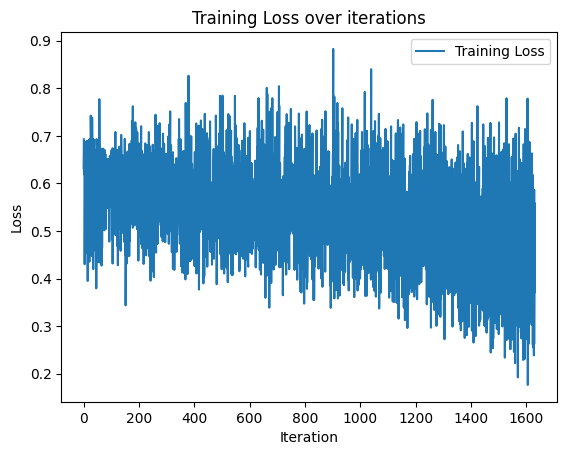

In [ ]:
import matplotlib.pyplot as plt

# Pérdida del modelo
train_loss = train_summary.read_scalar("Loss")

x_train = [x[0] for x in train_loss]     # iteración
y_train = [x[1] for x in train_loss]     # valor de la pérdida

plt.figure()
plt.plot(x_train, y_train, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss over iterations")
plt.legend()
plt.show()


Realizamos predicciones en el conjunto de prueba.

In [ ]:
# Prediciones en el conjunto de prueba
predictions = nn_model.transform(spark_df_test)
predictions.show(10, truncate=True)

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[0.46587009803921...|  0.0|       0.0|
|[0.02352941176470...|  0.0|       0.0|
|[0.03529411764705...|  0.0|       0.0|
|[0.01568627450980...|  0.0|       0.0|
|[0.08336780024509...|  0.0|       1.0|
|[0.12239583333333...|  0.0|       0.0|
|[0.06274509803921...|  0.0|       0.0|
|[0.35214460784313...|  0.0|       1.0|
|[0.01274509803921...|  0.0|       0.0|
|[0.10223987055759...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 10 rows




Obtenemos las métricas de rendimiento del modelo, en este caso la accuracy, que se define como el número de verdaderos positivos y verdaderos negativos dividido entre el total de predicciones realizadas.

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Precisión como metrica
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = ", accuracy)


Test set accuracy =  0.8317307692307693


#Guardado y carga del modelo

Guardado del modelo generado.

In [ ]:
# Guardar el modelo
nn_model.write().overwrite().save("/tmp/nnModel")

Carga del modelo.

In [ ]:
# Cargar el modelo
from bigdl.dllib.nnframes.nn_classifier import NNModel
loaded_model = NNModel.load("/tmp/nnModel")

# Conclusiones del trabajo

**Ventajas de BigDL**

Escalabilidad y velocidad: BigDL se integra de forma nativa con Spark, lo cual permite distribuir el entrenamiento y procesar grandes volúmenes de datos de manera eficiente. Esto resulta en una velocidad de cómputo notablemente superior, por ejemplo, para este trabajo se logro una precisión en el conjunto de prueba del 83% en tan solo 6 minutos.


**Limitaciones y problemas**

Falta de un parámetro seed: A diferencia de otras librerías de deep learning, BigDL no ofrece un método sencillo (por ejemplo model.setSeed(...)) que garantice reproducibilidad total en la inicialización de pesos y la partición de datos. Aunque se pueden fijar semillas en el contexto de Spark en la práctica no hay un control asegure la misma reproducibilidad en un entorno distribuido.

Problemas de visualización con TensorBoard: Aunque la documentación indica cómo instalar TensorBoard para visualizar métricas, la versión recomendada (1.0.0a4) es una alfa muy antigua, lo que sugiere que esta herramienta no ha sido optimizada para las versiones actuales de TensorFlow y pip. Esto genera problemas de compatibilidad, al punto de que ni siquiera Colab pueden descargarla correctamente. La ejecución de la version más moderna de esta herramienta no funciona, puesto que el localhost que genera esta vacío.

Complejidad de depuración y resolución de errores: Cuando surgen errores de forma o tipo de dato, el debugging en modo distribuido puede ser complicado; los mensajes de error no siempre son tan descriptivos.

Curva de aprendizaje: La API de BigDL (sobre todo en versiones más antiguas como la que he usado) requiere tener en mente diversas particularidades de dicha version de BigDL y Spark, lo cual aumenta la complejidad para usuarios novatos.

**Resumen final**

BigDL es una excelente alternativa para quienes desean entrenar redes neuronales en Spark de forma distribuida, logrando gran velocidad en el procesamiento de grandes volúmenes de datos.
La principal crítica radica en la falta de un método único para fijar la semilla (seed) que brinde reproducibilidad absoluta en entornos distribuidos, y en la complejidad que puede implicar la depuración de errores.
Con todo, su capacidad de escalar y procesar grandes volúmenes de datos hacen de Spark & BigDL una opción muy conveniente para entornos que manejen grandes volumenes de datos donde la velocidad y la distribución son prioritarias.